[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/search/faiss-ebook/locality-sensitive-hashing-random-projection/hyperplanes.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/search/faiss-ebook/locality-sensitive-hashing-random-projection/hyperplanes.ipynb)

In [1]:
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt

We will start with a few simple 2D vectors that we can visualize easily.

In [2]:
points = np.asarray([[1, 20], [13, 10], [12, 11]])
points

array([[ 1, 20],
       [13, 10],
       [12, 11]])

(0.0, 20.5)

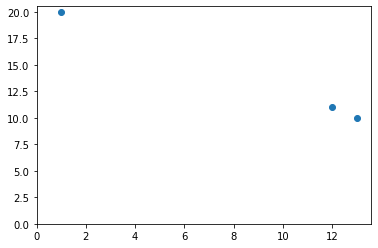

In [3]:
plt.scatter(points[:,0], points[:,1])
plt.xlim(0)
plt.ylim(0)

We will perform the splitting of our vectors by randomly creating new vectors which will act as the normal of a hyperplane centred at the origin *(0, 0)*.

In [4]:
def hash_vec(dim):
    return np.random.rand((dim)) - .5

In [5]:
h_vec = hash_vec(2)
h_vec

array([ 0.30298326, -0.36059008])

Let's first see if we can use this normal vector alongside the dot product to seperate our three vectors. The dot product will return a positive value if two vectors share the same direction, and a negative value if not (in the unlikely case of them being perfectly perpendicular the dot product value would be *0*).

In [6]:
def direction(vec, hash_vec):
    if np.dot(vec, hash_vec) > 0:
        return 1
    else:
        return 0

In [8]:
for xy in points:
    print(direction(xy, h_vec))

0
1
0


We have a functioning way of splitting our vectors now, but using a single split gives us very little indication about which vectors are similar or not - indeed, we would return only two buckets, *0* and *1* grouped vectors.

So, we need more hash functions - and the more we use, the better our LSH performance. Although we also want to balance this against search speed as the more buckets we use, the greater our search times. We will define the number of hyperplane splits using the variable `nbits`.

In [10]:
nbits = 8
hash_vecs = []

for n in range(nbits):
    hash_vecs.append(hash_vec(2))

hash_vecs = np.stack(hash_vecs)
hash_vecs

array([[-0.17632542, -0.28834479],
       [ 0.43623557,  0.23499209],
       [-0.37562719, -0.01141066],
       [-0.35437951, -0.12003665],
       [ 0.03774678, -0.09317542],
       [ 0.08486487,  0.08708127],
       [-0.22617495,  0.36291174],
       [-0.37251004, -0.47769561]])

Let's visualize these hyperplanes alongside our original three points.

(-5.0, 22.0)

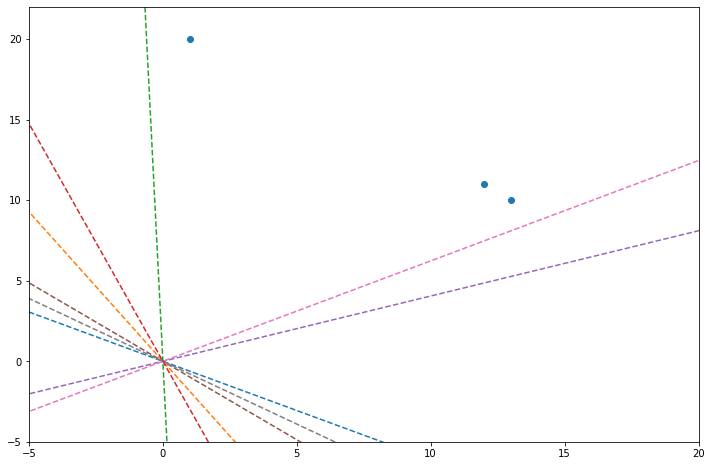

In [11]:
# we first turn each vector 90 degrees to represent our hyperplane edge
# (currently they are normal to the hyperplane - which is good for dot product but bad for visualizing)
def turn90(vec):
    return -vec[1], vec[0]

plt.figure(figsize=(12, 8))

for norm in hash_vecs:
    hyperplane = turn90(norm)
    # extend range of points so we see split across the chart
    hyperplane = [hyperplane[0]*-1000, hyperplane[0]*1000], [hyperplane[1]*-1000, hyperplane[1]*1000]
    # and plot
    plt.plot(hyperplane[0], hyperplane[1], '--')

plt.scatter(points[:,0], points[:,1])
plt.xlim(-5, 20)
plt.ylim(-5, 22)

We can see that most of our hash function splits are at an angle to our vectors as to not be particularly helpful. This is typical and not really an issue, the usual solution is to increase `nbits`. However, if we would like to - this issue can be solved by simply centering our data around the origin point.

All we do is take the average value of each dimension in our data, and subtract from our vector dimensions.

In [12]:
points = points - points.mean(axis=0)

(-10.0, 10.0)

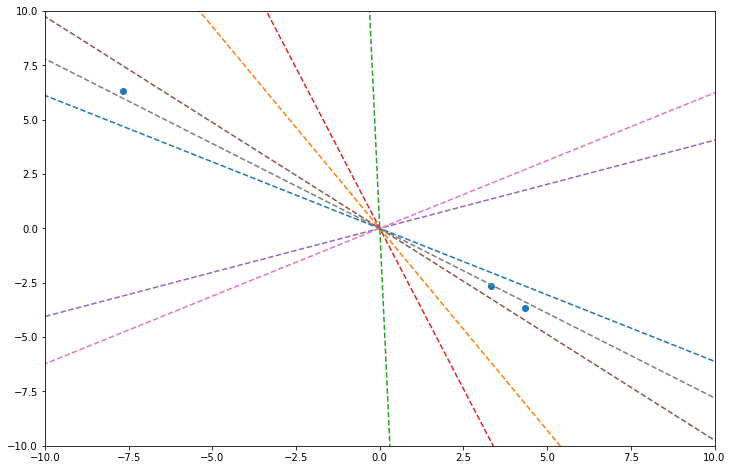

In [13]:
plt.figure(figsize=(12, 8))

for norm in hash_vecs:
    hyperplane = turn90(norm)
    # extend range of points so we see split across the chart
    hyperplane = [hyperplane[0]*-1000, hyperplane[0]*1000], [hyperplane[1]*-1000, hyperplane[1]*1000]
    # and plot
    plt.plot(hyperplane[0], hyperplane[1], '--')

plt.scatter(points[:,0], points[:,1])
plt.xlim(-10, 10)
plt.ylim(-10, 10)

We now have a much better split. Let's go ahead and create our binary hash values.

In [15]:
for xy in points:
    binary_hash = ''
    for h_vec in hash_vecs:
        binary_hash += str(direction(xy, h_vec))
    print(binary_hash)

00110010
11001101
11001101


We now have our three hash functions, and from this we can identify that vectors *2* and *3* are both being identified as strong candidate pairs and assigned the exact same hash code - which is exactly what we want!